In [1]:
# MO444-A 2s/2017 - Third assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold

def loadIDs():
    lines=[]
    with open('documents/ids', "r") as f:
        lines = f.read().splitlines()
    return np.asarray(lines)

def loadFeatures():
    features = pd.read_csv('documents/data.csv', sep=',', header=None)
    return features.values

def loadDocument(docID):
    data = None
    with open('documents/docs/' + docID, 'r') as docfile:
        data = docfile.read().replace('\n', '')
    return data

def runKFoldClustering(model, data):
    random_state = np.random.RandomState(1)
    k5_fold = KFold(n_splits=5, shuffle=True, random_state=random_state)
    costs, sil_avgs = [], []
    for train_index, validation_index in k5_fold.split(data):
        train_data, validation_data = data[train_index], data[validation_index]
        model.fit(train_data)
        labels = model.predict(validation_data)
        costs.append(model.inertia_)
        sil_avgs.append(silhouette_score(validation_data, labels))
    return np.mean(costs), np.std(costs), np.mean(sil_avgs), np.std(sil_avgs)


In [2]:
ids = loadIDs()
print('IDs shape: {}'.format(ids.shape))

data = loadFeatures()
print('Data shape: {}'.format(data.shape))

IDs shape: (19924,)
Data shape: (19924, 2209)


In [3]:
# Let's look at the 5 first instances of the IDs
print(ids[0:5])

['832e15531654188fa0b951faa5f68540dfb1ca5a'
 'aa5163928a6edfd3bf69fd11fe763aacecf4602d'
 'e886703afff0c70d6598bcae0c2d69a5a237807f'
 'c1ea507b177b2e1673ce7a576057f91b75ae9d29'
 'bbf73405c85d22702fafc1c0916e8f713810ff8d']


In [4]:
# Now, let's have a look at the 5 first instances of the data (bag-of-words feature vectors)
data_frame = pd.DataFrame(data)
data_frame.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2199,2200,2201,2202,2203,2204,2205,2206,2207,2208
0,0.077257,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.055755,0.0,0.0
2,0.042250,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.093693,0.0,0.099296,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.069105,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.036811,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.000000,0.041917,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [5]:
# Checking the value ranges
print('Min. value: {}'.format(np.min(data.flatten())))
print('Max. value: {}'.format(np.max(data.flatten())))

# Let's scale and normalize the data
data = scale(data)

normalizer = Normalizer()
normalizer = normalizer.fit(data)

data = normalizer.transform(data)

Min. value: 0.0
Max. value: 0.999901


In [6]:
# Attempting Mini-Batch K means with some different number of centroids.
kmeans, costs, costs_sd, sil_avgs, sil_avgs_sd = [], [], [], [], []
num_centroids = [2, 4, 8, 16, 32, 64, 128, 256, 512]
for i in num_centroids:
    model = MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=1000, random_state=1)
    cost_mean, cost_sd, sil_avg, sil_avg_sd = runKFoldClustering(model, data)
    kmeans.append(model)
    costs.append(cost_mean)
    costs_sd.append(cost_sd)
    sil_avgs.append(sil_avg)
    sil_avgs_sd.append(sil_avg_sd)
    print '%d clusters: Cost %5.2f ±%5.2f ; Silhouette avg %5.5f ±%5.5f' % (i, cost_mean, cost_sd, sil_avg, sil_avg_sd)

2 clusters: Cost 15839.92 ± 0.76 ; Silhouette avg 0.00618 ±0.00013
4 clusters: Cost 15756.58 ± 5.40 ; Silhouette avg 0.00483 ±0.00026
8 clusters: Cost 15602.82 ±14.17 ; Silhouette avg 0.00658 ±0.00040
16 clusters: Cost 15409.90 ±11.12 ; Silhouette avg 0.00973 ±0.00067
32 clusters: Cost 15100.33 ±24.79 ; Silhouette avg 0.01374 ±0.00098
64 clusters: Cost 14667.04 ±12.01 ; Silhouette avg 0.01799 ±0.00112
128 clusters: Cost 14210.46 ±20.63 ; Silhouette avg 0.01795 ±0.00060
256 clusters: Cost 13816.03 ±42.99 ; Silhouette avg 0.01376 ±0.00115
512 clusters: Cost 13738.17 ±150.86 ; Silhouette avg -0.00415 ±0.00405


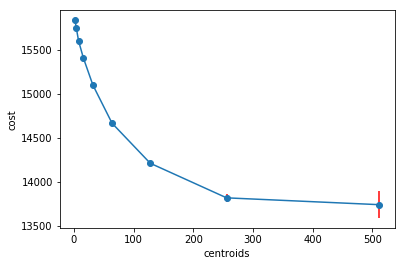

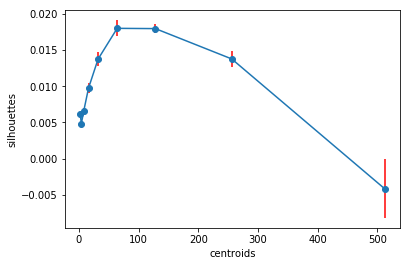

In [7]:
# Plot an elbow curve.
plt.plot(color='blue', marker='o')
plt.errorbar(num_centroids, costs, yerr=costs_sd, 
             fmt='-o', ecolor='r', capthick=2)
plt.xlabel('centroids')
plt.ylabel('cost')
plt.show()

# Plot the silhouette averages
plt.plot(color='blue', marker='o')
plt.errorbar(num_centroids, sil_avgs, yerr=sil_avgs_sd, 
             fmt='-o', ecolor='r', capthick=2)
plt.xlabel('centroids')
plt.ylabel('silhouettes')
plt.show()

In [8]:
# Chosen number of centroids: 64
chosen_model = kmeans[5]
chosen_model_labels = chosen_model.predict(data)

In [9]:
# Let's check three sample groups, their medoid documents, and two other closer documents.
for i in [26, 32, 58]:
    print('Group: %d' % i)
    center = chosen_model.cluster_centers_[i]
    group_points = data[chosen_model_labels == i]
    group_doc_ids = ids[chosen_model_labels == i]

    # Let's find the medoid and their closest points
    distancesMatrix = pairwise_distances(group_points, metric='euclidean')
    closest_to_medoid_indexes = np.argsort(distancesMatrix.sum(axis=0))
    medoid_index = closest_to_medoid_indexes[0]

    print(' - Medoid doc: {}'.format(group_doc_ids[medoid_index]))
    print(loadDocument(group_doc_ids[medoid_index]))
    print(' - ')
    print(' -- Closest to medoid doc: {}'.format(group_doc_ids[closest_to_medoid_indexes[1]]))
    print(loadDocument(group_doc_ids[closest_to_medoid_indexes[1]]))
    print(' -- ')
    print(' --- Second closest to medoid doc: {}'.format(group_doc_ids[closest_to_medoid_indexes[2]]))
    print(loadDocument(group_doc_ids[closest_to_medoid_indexes[2]]))
    print(' --- ')

Group: 26
 - Medoid doc: aad5914b9868c167169550405fdcd99f786035ed
Newsgroups: talk.politics.gunsPath: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!usc!cs.utexas.edu!convex!convex!bjonesFrom: bjones@convex.com (Brad Jones)Subject: Re: Letter to the PresidentSender: usenet@news.eng.convex.com (news access account)Message-ID: <bjones.735320585@neptune>Date: Tue, 20 Apr 1993 15:43:05 GMTReferences: <1993Apr20.140647.6274@icd.ab.com>Nntp-Posting-Host: neptune.convex.comOrganization: Engineering, CONVEX Computer Corp., Richardson, Tx., USAX-Disclaimer: This message was written by a user at CONVEX Computer              Corp. The opinions expressed are those of the user and              not necessarily those of CONVEX.Lines: 8kdw@icd.ab.com (Kenneth D. Whitehead) writes:>the dismissal or resignation of Lloyd Bensen, Secretary of the Treasury,In case you haven't sent it yet, it's "Bentsen", not "Bensen".Brad
 -